# Getting Data: Web & Text

Today we will be looking at scraping data from websites that have no API and work with manipulating text data.

## Extracting tables from websites using Pandas

Yes it is true, Pandas can do just about everything.  We will use a Pandas function that can read information from websites that is stored in tables.

### The Website: Box Office Mojo

[boxofficemojo.com](https://www.boxofficemojo.com) contains a wealth of information on the performance of movies during their theater runs.  We will practice extracting some of the information from the tables hosted on the site.

**First!** We need to check to see if the site has any policies against scraping and automated access.  Let us check their [robots.txt](https://www.boxofficemojo.com/robots.txt) file.  Click on the link and take a look.  It seems that automated data collection is allowed in all regions of the website.

Now we will select a data table.  Let us look at the top movies for the weekend of January 3-5, 2020 (the first weekend in January)

https://www.boxofficemojo.com/weekend/2020W01/

You should do the following.

1. Click on the link and inspect the contents of the page.
2. While on the page, look at the structure of the HTML that is used to format the data table.  You can see the HTML of any page by inspecting the page source.  The exact way you do this depends on your browser, in Chrome it is: Click on the View menu, then Developer, then View Source.

Ok, now let's go get that data!

In [ ]:
import pandas as pd

tables = pd.read_html("https://www.boxofficemojo.com/weekend/2020W01/")

`tables` is a list of tables from the page.  Let's see how many there are.

In [ ]:
len(tables)

1

Let's see what data is in each table.

In [ ]:
for t in tables:
    display(t.head())

,Rank,LW,Release,Gross,%± LW,Theaters,Change,Average,Total Gross,Weeks,Distributor,New This Week,Estimated
0,1,1,Star Wars: Episode IX - The Rise of Skywalker,"$34,524,815",-52.3%,4406,-,"$7,835","$451,582,256",3,Walt Disney Studios Motion Pictures,False,False
1,2,2,Jumanji: The Next Level,"$26,227,346",-25.6%,4134,-93,"$6,344","$235,933,751",4,Sony Pictures Releasing,False,False
2,3,4,Little Women,"$13,612,373",-18.8%,3308,-,"$4,114","$60,060,705",2,Sony Pictures Releasing,False,False
3,4,3,Frozen II,"$11,854,169",-29.8%,3175,-90,"$3,733","$450,439,533",7,Walt Disney Studios Motion Pictures,False,False
4,5,-,The Grudge,"$11,404,113",-,2642,-,"$4,316","$11,404,113",1,Sony Pictures Releasing,True,False


There is only one table in this case and the one has the data we want.

In [ ]:
movieData = tables[0]

movieData.head()

,Rank,LW,Release,Gross,%± LW,Theaters,Change,Average,Total Gross,Weeks,Distributor,New This Week,Estimated
0,1,1,Star Wars: Episode IX - The Rise of Skywalker,"$34,524,815",-52.3%,4406,-,"$7,835","$451,582,256",3,Walt Disney Studios Motion Pictures,False,False
1,2,2,Jumanji: The Next Level,"$26,227,346",-25.6%,4134,-93,"$6,344","$235,933,751",4,Sony Pictures Releasing,False,False
2,3,4,Little Women,"$13,612,373",-18.8%,3308,-,"$4,114","$60,060,705",2,Sony Pictures Releasing,False,False
3,4,3,Frozen II,"$11,854,169",-29.8%,3175,-90,"$3,733","$450,439,533",7,Walt Disney Studios Motion Pictures,False,False
4,5,-,The Grudge,"$11,404,113",-,2642,-,"$4,316","$11,404,113",1,Sony Pictures Releasing,True,False


Now we shall take a look at the data by making some scatter plots to investigate relationships between pairs of columns.  First, we can compare **Gross** with **Weeks** to see if new movies make more money than those that have been out for a while. 

Hmm, looking at **Gross**, we can see there are dollar signs in the values given which means that those entries are not just numbers.  This could confuse our plotting routines.

In [ ]:
movieData.dtypes

Rank              int64
LW               object
Release          object
Gross            object
%± LW            object
Theaters          int64
Change           object
Average          object
Total Gross      object
Weeks             int64
Distributor      object
New This Week      bool
Estimated          bool
dtype: object

In [ ]:
# Get rid of dollar signs and commas then cast as a number
movieData["Gross"].replace('[\$,]', '', regex=True, inplace=True)
movieData["Gross"] = movieData["Gross"].apply(pd.to_numeric)

# Do Total Gross too
movieData["Total Gross"].replace('[\$,]', '', regex=True, inplace=True)
movieData["Total Gross"] = movieData["Total Gross"].apply(pd.to_numeric)

movieData.dtypes

Rank              int64
LW               object
Release          object
Gross             int64
%± LW            object
Theaters          int64
Change           object
Average          object
Total Gross       int64
Weeks             int64
Distributor      object
New This Week      bool
Estimated          bool
dtype: object

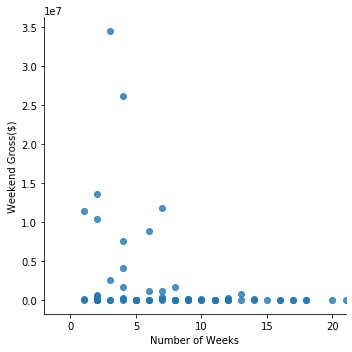

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.lmplot(x='Weeks', y='Gross', data=movieData, fit_reg=False)
ax = plt.gca()
ax.set_xlim(-2, 21)
ax.set_ylabel('Weekend Gross(\$)')
ax.set_xlabel('Number of Weeks');

Now let's look to see if movies that have been out longer make more money overall.

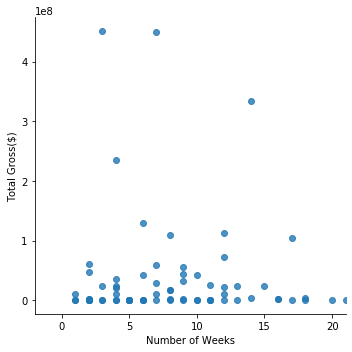

In [ ]:
sns.lmplot(x='Weeks', y='Total Gross', data=movieData, fit_reg=False)
ax = plt.gca()
ax.set_xlim(-2, 21)
ax.set_ylabel('Total Gross(\$)')
ax.set_xlabel('Number of Weeks');

In [ ]:
# TASK 1: Repeat the above analysis for the most recent weekend. You can do this by repeating
# the code above, making the appropriate changes or you can just modify the first code cell
# and re-run all the cells to this point.
sns.lmplot(x='Weeks', y='Total Gross', data=movieData, fit_reg=False)
ax = plt.gca()
ax.set_xlim(-2, 21)
ax.set_ylabel('Total Gross(\$)')
ax.set_xlabel('Number of Weeks');

## Beautiful Soup

The Pandas read_html function works great for simple tables.  For websites that contain information in a less structured format, we will need to use an HTML parser, such as Beautiful Soup.

In [ ]:
from bs4 import BeautifulSoup
import requests
import re

We will use Beautiful Soup to extract information from the archive of National Public Radio technology news stories.  

**First** have a look at NPR's [robots.txt](https://www.npr.org/robots.txt)

There is nothing there that disallows scraping of the news stories.

Now we will get the html from [here](https://www.npr.org/sections/technology/archive) and inspect it.  You should open this page in a different tab so that you can compare the html with the page.

In [ ]:
url = 'https://www.npr.org/sections/technology/archive'
html = requests.get(url).text

soup = BeautifulSoup(html, 'html5lib') # parse the html

print(soup.prettify()) # print a nicely formatted look at the html

You will need to scroll down a ways to start seeing the stories.  Here is the html for an example story:

Each article entry is spanned by `<article></article>` tags.  We will first pull out all of these articles.

In [ ]:
articles = soup.find_all('article')
len(articles)  # How many articles did we get?

In [ ]:
articles[0] # Look at the content of the first article

The data about the article is stored in `<div>` elements.  We can find the title of the first story by finding the `<div>` element with the `item-info` attribute.  The title is the text portion under a header element.  

In [ ]:
title = articles[0].find("div", "item-info").h2.text
title

'SXSW Events Canceled Over Coronavirus Concerns'

There is a blurb or "teaser" describing the article that is also stored in the `<div>` element with the `item-info` attribute.

In [ ]:
teaser = articles[0].find("div", "item-info").p.text
teaser

'March 7, 2020 • South by Southwest — a massive art, music and technology festival — has been canceled over fears that visitors might help spread the coronavirus in Austin, Texas.'

We can see that the `<p>` element contains both the date and the teaser, which we want to separate.

In [ ]:
date = articles[0].find("div", "item-info").p.span.text
date

'March 7, 2020 • '

In [ ]:
teaser = teaser.replace(date, '')
teaser

'South by Southwest — a massive art, music and technology festival — has been canceled over fears that visitors might help spread the coronavirus in Austin, Texas.'

The date can be split into month, day and year using regular expressions. Putting round parentheses `()` around a part of the regular expression designates it as a group that can be referenced once a match has been found.

In [ ]:
import re

dmatch = re.match(r'([a-zA-Z]+) (\d+), (\d+)', date)
print('The whole match = ', dmatch.group(0))
month = dmatch.group(1)
print('Month = ', month)
day = dmatch.group(2)
print('Day = ', day)
year = dmatch.group(3)
print('Year = ', year)

The whole match =  March 7, 2020
Month =  March
Day =  7
Year =  2020


Lastly, we will want to extract the url for the article.

In [ ]:
url = articles[0].find("div", "item-info").h2.a.get('href')
url

'https://www.npr.org/2020/03/07/813192987/sxsw-events-canceled-over-coronavirus-concerns'

In [ ]:
# TASK 2 - In the <p class="teaser"> element there is a <time> element that contains the 
# date in a the format 2019-01-15 
# Extract this date for articles[0] and store it in a variable called date2


Now that we have had some practice with a single article, we will pull out the above information for all of the articles.

In [ ]:
def isaudio(article):
    """isaudio(article)
    Some "articles" are not true articles but just add buttons
    to the previously listed article to play an audio version 
    of the story
    Input: article
    Output: returns True if the article is audio buttons, False
    otherwise"""
     
    return article.get('class')[0] == 'bucketwrap'

def articleinfo(article):
    """title, teaser, date, url = articleinfo(article)
    articleinfo - pulls information from an article's html 
    Input: article
    Outputs: title, teaser, date, url"""
    
    # Skip audio-module "articles" which are not true articles
    # but just add buttons to play audio
    
    if not isaudio(article):
        title = article.find("div", "item-info").h2.text
        teaser = article.find("div", "item-info").p.text
        date = article.find("div", "item-info").p.span.text
        teaser = teaser.replace(date, '')
        url = article.find("div", "item-info").h2.a.get('href')
    else:
        title = []
        teaser = []
        date = []
        url = []
    
    return (title, teaser, date, url)


In [ ]:
titles = []
teasers = []
dates = []
urls = []

for article in articles:
    title, teaser, date, url = articleinfo(article)
    if title != []:
        titles.append(title)
        teasers.append(teaser)
        dates.append(date)
        urls.append(url)
        

In [ ]:
# Parse the dates
months = []
days = []
years = []
for date in dates:
    dmatch = re.match(r'([a-zA-Z]+) (\d+), (\d+)', date)
    months.append(dmatch.group(1))
    days.append(dmatch.group(2))
    years.append(dmatch.group(3))

Now we will build a pandas DataFrame with our information.

In [ ]:
nprtech = pd.DataFrame({'Title': titles, 'Teaser': teasers, 'Month': months,
                       'Day': days, 'Year': year, 'url': urls})
nprtech.head()

,Title,Teaser,Month,Day,Year,url
0,SXSW Events Canceled Over Coronavirus Concerns,"South by Southwest — a massive art, music and ...",March,7,2020,https://www.npr.org/2020/03/07/813192987/sxsw-...
1,The Show Will Not Go On: Austin Cancels SXSW B...,"""We are devastated to share this news with you...",March,6,2020,https://www.npr.org/2020/03/06/813023174/the-s...
2,How Russia Is Trying To Boost Bernie Sanders' ...,Sen. Sanders says he was briefed by the intell...,March,5,2020,https://www.npr.org/2020/03/05/812186614/how-r...
3,Report: Russian Election Trolling Becoming Sub...,A cache of Instagram posts has yielded what re...,March,5,2020,https://www.npr.org/2020/03/05/812497423/repor...
4,Coronavirus Concerns Stymie Live Music Perform...,"Organizers, public officials, musicians and ot...",March,5,2020,https://www.npr.org/2020/03/05/812487700/coron...


In [ ]:
# Task 3 - Repeat the work above to collect article information from NPR's science archive
# https://www.npr.org/sections/science/archive
# Put the information in a pandas DataFrame called nprsci and then merge the two into a single 
# DataFrame via
# nprscitech = nprsci.append(nprtech, ignore_index=True)



Are there any technology articles about Facebook?

In [ ]:
nprtech[nprtech['Title'].str.contains("Facebook") | nprtech['Teaser'].str.contains("Facebook")]

,Title,Teaser,Month,Day,Year,url
5,"Amazon, Facebook, Google, Microsoft Tell Seatt...",U.S. companies are trying to limit disruption ...,March,5,2020,https://www.npr.org/2020/03/05/812173963/coron...


In [ ]:
# Task 4
# Search the collected news articles for another tech company or term of your choice